#  Titanic Survival Exploration with Decision Trees

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from pandas import read_csv
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(pd.isnull(train).sum(),"\n------------\n",pd.isnull(test).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 
------------
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
train[["Sex", "Survived"]].groupby(["Sex"]).mean()*100


,Survived
Sex,
female,74.203822
male,18.890815


In [5]:
train[["Pclass", "Survived"]].groupby(["Pclass"]).mean()*100


,Survived
Pclass,
1,62.962963
2,47.282609
3,24.236253


In [6]:
train[["Embarked", "Survived"]].groupby(["Embarked"]).mean()*100

,Survived
Embarked,
C,55.357143
Q,38.961039
S,33.695652


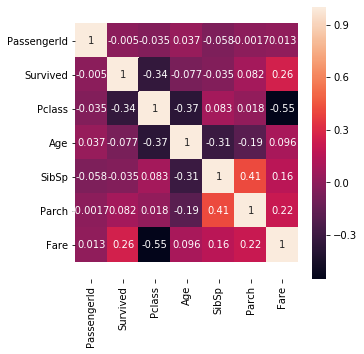

In [7]:
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(train.corr(), annot=True)


bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

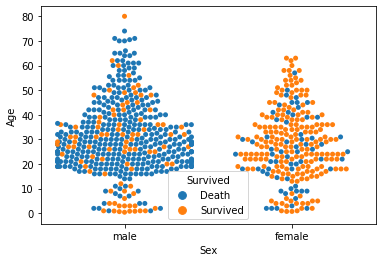

In [8]:
survived_map = {1:"Survived", 0:"Death"}

sns.swarmplot(x="Sex", y="Age", 
              hue=train["Survived"].map(survived_map).copy(), 
              data=train)
plt.show()

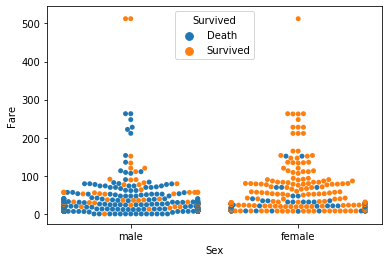

In [9]:
survived_map = {1:"Survived", 0:"Death"}

sns.swarmplot(x="Sex", y="Fare", 
              hue=train["Survived"].map(survived_map).copy(), 
              data=train)
plt.show()


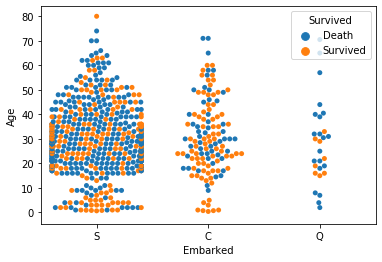

In [10]:
survived_map = {1:"Survived", 0:"Death"}

sns.swarmplot(x="Embarked", y="Age", 
              hue=train["Survived"].map(survived_map).copy(), 
              data=train)
plt.show()

In [11]:
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [12]:

train.drop("PassengerId",axis=1,inplace=True)
train.drop(["Cabin","Name","Ticket"], axis=1, inplace=True)
test.drop(["Cabin","Name","Ticket"], axis=1, inplace=True)


train["Alone?"] = train["SibSp"]+train["Parch"]+1
train.drop(["SibSp","Parch"], axis=1, inplace=True)

test["Alone?"] = test["SibSp"]+test["Parch"]+1
test.drop(["SibSp","Parch"], axis=1, inplace=True)


bins = [0,1,4,11]
labels = ["Alone","NotAlone","Crowd"]
train["Person"] = pd.cut(train["Alone?"],bins, labels = labels, include_lowest = True)

person_map = {"Alone":1, "NotAlone":2, "Crowd":3}
train["Person"] = train["Person"].map(person_map)
train.drop("Alone?", axis=1, inplace=True)

bins = [0,1,4,11]
labels = ["Alone","NotAlone","Crowd"]
test["Person"] = pd.cut(test["Alone?"],bins, labels = labels, include_lowest = True)

person_map = {"Alone":1, "NotAlone":2, "Crowd":3}
test["Person"] = test["Person"].map(person_map)
test.drop("Alone?", axis=1, inplace=True)

train.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Person
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


In [13]:
def age_train(x):
    train_mean = train[x].mean()
    train_std = train[x].std()
    train_null = train[x].isnull().sum()
    return np.random.randint(train_mean - train_std, train_mean + train_std, size = train_null)
def age_test(x):
    test_mean = test[x].mean()
    test_std = test[x].std()
    test_null = test[x].isnull().sum()
    return np.random.randint(test_mean - test_std, test_mean + test_std, size = test_null)

train["Age"][np.isnan(train["Age"])] = age_train("Age")
test["Age"][np.isnan(test["Age"])] = age_test("Age")


train["Age"] = train["Age"].astype("int64")
test["Age"] = test["Age"].astype("int64")

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Person
0,0,3,male,22,7.2500,S,2
1,1,1,female,38,71.2833,C,2
2,1,3,female,26,7.9250,S,1
3,1,1,female,35,53.1000,S,2
4,0,3,male,35,8.0500,S,1


In [14]:
test["Fare"].fillna(test["Fare"].median(), inplace = True)
train["Fare"] = train["Fare"].astype("int64")
test["Fare"] = test["Fare"].astype("int64")

train["FareGroup"] = pd.qcut(train["Fare"], 4, labels = [1,2,3,4])
train.drop("Fare", axis=1, inplace=True)

test["FareGroup"] = pd.qcut(test["Fare"], 4, labels = [1,2,3,4])
test.drop("Fare", axis=1, inplace=True)

In [15]:
train = train.fillna({"Embarked": "S"})

embarked_map = {"S": 0, "C": 1, "Q":2}
train["Embarked"] = train["Embarked"].map(embarked_map)

embarked_map = {"S": 0, "C": 1, "Q":2}
test["Embarked"] = test["Embarked"].map(embarked_map)

train["Embarked"] = train["Embarked"].astype("int64")
test["Embarked"] = test["Embarked"].astype("int64")

In [16]:
sex_map = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_map)

sex_map = {"male": 0, "female": 1}
test["Sex"] = test["Sex"].map(sex_map)

train["Sex"] = train["Sex"].astype("int64")
test["Sex"] = test["Sex"].astype("int64")

In [17]:
bins = [0,18,30,50,70,120]
labels = ["0-17","18-29","30-49","50-69","70+"]
train["AgeGroup"] = pd.cut(train["Age"],bins, labels = labels, include_lowest = True)

age_mapping = {"0-17":0, "18-29":1, "30-49":2, "50-69":3, "70+":4}
train["AgeGroup"] = train["AgeGroup"].map(age_mapping)
train.drop("Age", axis=1, inplace=True)

train.head()

,Survived,Pclass,Sex,Embarked,Person,FareGroup,AgeGroup
0,0,3,0,0,2,1,1
1,1,1,1,1,2,4,2
2,1,3,1,0,1,1,1
3,1,1,1,0,2,4,2
4,0,3,0,0,1,2,2


In [44]:
bins = [0,18,30,50,70,120]
labels = ["0-17","18-29","30-49","50-69","70+"]
test["AgeGroup"] = pd.cut(test["Age"],bins, labels = labels, include_lowest = True)

age_mapping = {"0-17":0, "18-29":1, "30-49":2, "50-69":3, "70+":4}
test["AgeGroup"] = test["AgeGroup"].map(age_mapping)
test.drop("Age", axis=1, inplace=True)

test.head()

,PassengerId,Pclass,Sex,Embarked,Person,FareGroup,AgeGroup
0,892,3,0,2,1,1,2
1,893,3,1,0,2,1,2
2,894,2,0,2,1,2,3
3,895,3,0,0,1,2,1
4,896,3,1,0,2,2,1


In [45]:
from sklearn.model_selection import train_test_split

independent_var = train.drop(["Survived"], axis=1)
dependent_var = train["Survived"]
x_train, x_test, y_train, y_test = train_test_split(independent_var, dependent_var, 
                                                  test_size = 20, random_state = 0)

In [46]:
models = []
models.append(SVC())
models.append(LinearSVC())
models.append(Perceptron())
models.append(GaussianNB())
models.append(SGDClassifier())
models.append(LogisticRegression())
models.append(KNeighborsClassifier())
models.append(RandomForestClassifier())
models.append(DecisionTreeClassifier())
models.append(GradientBoostingClassifier())

accuracy_list = []
for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = (accuracy_score(y_pred, y_test, normalize=True)*100)
    accuracy_list.append(accuracy)


model_name_list = ["SVM","Linear SVC","Perceptron","Gaussian NB","SGD Classifier","Logistic Regression",
                   "K-Neighbors Classifier","Random Forest Classifier","Decision Tree","Gradient Boosting"]

best_model = pd.DataFrame({"Model": model_name_list, "Score": accuracy_list})
best_model.sort_values(by="Score", ascending=False)

,Model,Score
5,Logistic Regression,90.0
3,Gaussian NB,85.0
4,SGD Classifier,85.0
6,K-Neighbors Classifier,85.0
8,Decision Tree,85.0
0,SVM,80.0
1,Linear SVC,80.0
7,Random Forest Classifier,80.0
9,Gradient Boosting,80.0
2,Perceptron,75.0


In [48]:
DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)

passanger_id = test["PassengerId"]
pred = DT.predict(test.drop("PassengerId", axis=1))
predictions = pd.DataFrame({ "PassengerId" : passanger_id, "Survived": pred })


In [49]:
predictions.to_csv("submission.csv", index=False)

In [65]:
test1 = test.drop("PassengerId", axis=1)
test1 = test1.astype('int64')

,Pclass,Sex,Embarked,Person,FareGroup,AgeGroup
0,3,0,2,1,1,2
1,3,1,0,2,1,2
2,2,0,2,1,2,3
3,3,0,0,1,2,1
4,3,1,0,2,2,1
5,3,0,0,1,2,0
6,3,1,2,1,1,1
7,2,0,0,2,3,1
8,3,1,1,1,1,0
9,3,0,0,2,3,1


In [73]:
clf_xgb = XGBClassifier()
clf_xgb.fit(x_train.astype('int64'), y_train.astype('int64'))

pred = clf_xgb.predict(test1.astype('int64'))
predictions = pd.DataFrame({ "PassengerId" : passanger_id, "Survived": pred })
